In [78]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
import scipy
from scipy.optimize import curve_fit
from data_list_creator import create_data, gate_string_to_list, gate_list_to_string, SNR, find_max_power, find_band_power

#################################################################################################################
gate_string = "(Gx)^49"
nSamples = 5000  #total samples to take for each measurement
nCounts = 1   #total shots to take at one; =nSamples: same noise, probabilities for all repeats; =1, new experiment & noise for each count
time_per_count = 1/60 #seconds
time_units = 1e-3 #seconds. This should be the max resolution you expect to input at any given time (i.e. everthing on the scale of 1e-3 s or more)
res = 1
noise_type='Sine' #Sine, Random Walk, Telegraph
plot_noise=False

walking_amp = 0.0001
low_frequency_noise = [np.round(0.0015*i, 4) for i in range(5)]
low_frequency_noise = [] #uncomment this to eliminate low_frequency noise
low_frequency_amps = [0.005*i for i in range(len(low_frequency_noise))]
low_frequency_phase = [0]*len(low_frequency_noise)
freq_list=[1.2]#, 6, 8.4, 9.6] + low_frequency_noise
amp_list=[0.008]#[0.002, 0.002, 0.0015, 0.0015] + low_frequency_amps
phase_list=[0]#,0,0,0] + low_frequency_phase
telegraph_amp = 0.02
start_f = 0.1
stop_f = 2
fluctuators= 40
add_noise=None#0.001

num_experiments = 2 #how many times you want to run a single set of parameters
variable_params = [[i*0.002] for i in range(0, 20)]#[(i*0.0005,) for i in range(0,75, 5)]#[(i*0.001 + 0.002,) for i in range(4,15)]
param_name = 'amp' #'frequency', 'nSamples', 'L', 'amp'

#parameters for SNR analysis below
snr_bandwidth = 0.01 #frequency range in Hz
snr_central_freq = 1.2 #Hz. SNR will scan central-band up to central+band
freq_of_interest = snr_central_freq #Hz
freq_scan = 0.1#Hz

#####This part below is just if you want to manipulate a list of amplitudes as the variable parameter
##### It will replace variable params with lists of integer multiples of "base_amps" for 9 frequencies
special_amp_params = False
if param_name=='amp' and special_amp_params:
    base_amps = [0.002, 0.002, 0.0015, 0.0015, 0.005, 0.005, 0.010, 0.015,0.020] 
    low_incr = -5
    high_incr = 10
    step = 0.0001
    variable_params = []
    for incr in range(low_incr, high_incr):
        params_element = [0]*len(base_amps)
        for elem_index in range(len(base_amps)):
            params_element[elem_index] = base_amps[elem_index] + (incr*step)
        variable_params.append(params_element)


##############################################################################################################
#Don't change anything below this line for regular program operation
freq_list = tuple(freq_list)
amp_list = tuple(amp_list)
phase_list = tuple(phase_list)
num_parameters = len(variable_params) #the number of different parameter sets that will be run num_experiment-times
time_per_sample = nCounts*time_per_count
#2D arrays which will contain the results, data, and top_freqs lists for each parameter & experiment

global_results_list = [0]*num_parameters
global_probs_list = [0]*num_parameters
global_max_probs_list = [0]*num_parameters #contains lists of the maximum 1-state probability for each parameter set (constant over num_experiments)
global_normalized_results_list = [0]*num_parameters
global_superimposed_lists = [0]*num_parameters
global_normalized_superimposed_lists = [0]*num_parameters
global_snr_list = [0]*num_parameters #contains average SNR for each set of parameters, using the superimposed/averaged spectrum
global_angle_list = [0]*num_parameters #will contain a list of rotation angles per time for each set of parameters
global_ideal_angle_list = [0]*num_parameters #lists of roation angles per time for each parameter set, but without any drift/noise
global_timestamps_list = [0]*num_parameters #contains a list of timestamps for each set of parameters
global_avg_total_power_list = [0]*num_parameters #stores total power for each parameter set, averaged across num_experiments
global_avg_peak_power_list = [0]*num_parameters #stores averaged power of selected frequency averaged across num_experiments
global_std_dev_peak_power_list = [0]*num_parameters #the std deviation of selected frequency power for num_experiments
global_avg_power_std_deviation_list = [0]*num_parameters #standard deviations for power of the averaged power spectrum over num_experiments
global_avg_normalized_peak_power_list = [0]*num_parameters #stores normalized avg power of selected frequency for  spectrum across num_experiments
global_std_dev_normalized_peak_power_list = [0]*num_parameters
global_normalized_peak_power_SNR_list = [0]*num_parameters

for param_index in range(num_parameters):
    ######This segment finds the appropriate parameter of interest and makes it variable
    if param_name == "frequency": freq_list = variable_params[param_index]
    elif param_name == "nSamples": nSamples = variable_params[param_index]
    elif param_name == "L": 
        gate_list = variable_params[param_index]
        gate_string = "(Gx)^" + str(gate_list)
    elif param_name == "amp": amp_list = variable_params[param_index]
    #################################
    sig = None
    results_list = []
    angle_list = []
    ideal_angle_list = []
    total_power_list = []
    peak_power_list = []
    normalized_results_list = []
    normalized_peak_power_list = []
    normalized_peak_power_SNR_list = []
    for exp_index in range(num_experiments):
        print("Currently on experiment {}".format(exp_index))
        #Initialize arrays of one-counts per timestep, zero-counts per timstep, the actual timesteps for each, and the probability of getting a 1 for each  
        ones_count_array, zeros_count_array,\
        timestamp_array, probs_array, ideal_angle_list, angle_list, sig = create_data( \
                                                   time_per_count, nSamples, nCounts, gate_string_to_list(gate_string), time_units,\
                                                   noise_type, walking_amp, telegraph_amp,res, freq_list, \
                                                   amp_list, phase_list, start_f, stop_f,fluctuators,plot_noise,add_noise, sig)
        counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
        drifted = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
        results_list.append(drifted)
        total_power_list.append(np.sum(drifted.pspepo_power_spectrum[0,0,1,:]))
        #find the power of the peak of interest here, append it to a list of peak powers for the given set of parameters
        peak_power = find_max_power(drifted.frequencies, drifted.pspepo_power_spectrum[0,0,1,:], freq_of_interest-freq_scan, freq_of_interest+freq_scan)
        peak_power_list.append(peak_power)
        #create normalized results here by dividing by number of data points
        normalized_powers = drifted.pspepo_power_spectrum[0,0,1,:]/len(ones_count_array)
        normalized_results_list.append(normalized_powers)
        #find the power & SNR of the peak of interest for the normalized spectrum, and append it to a list of peak powers
        norm_peak_power = find_max_power(drifted.frequencies, normalized_powers, freq_of_interest-freq_scan, freq_of_interest+freq_scan)
        normalized_peak_power_list.append(norm_peak_power)
        normalized_peak_power_SNR_list.append(SNR(drifted.frequencies, normalized_powers, snr_central_freq, snr_bandwidth))
        
    global_probs_list[param_index] = probs_array #probsarray will be the same for all num_experiments given the same parameters
    global_angle_list[param_index] = angle_list #same for all num_experiments
    global_ideal_angle_list[param_index] = ideal_angle_list #same for all num_experiments
    #append the list of maximum probabilities (same for all num_experiments, so just take the most recent experiment)
    global_max_probs_list[param_index] = np.max(probs_array)
    #average the total power obtained in each trial
    global_avg_total_power_list[param_index] = np.mean(total_power_list)
    #add the list of results objects to the global list
    global_results_list[param_index] = results_list
    #add a list of timestamps to the global list. this list is identical for all num-experiments with the same parameters.
    global_timestamps_list[param_index] = timestamp_array
    #for the given set of parameters, find std deviation and mean of the list of peak powers
    global_avg_peak_power_list[param_index] = np.mean(peak_power_list)
    global_std_dev_peak_power_list[param_index] = np.std(peak_power_list)
    #add the list containing the normalized power lists for each trial here (all have the same parameters)
    global_normalized_results_list[param_index] = normalized_results_list
    #find the std deviation and mean of the normalized peak powers for the given set of parameters
    global_avg_normalized_peak_power_list[param_index] = np.mean(normalized_peak_power_list)
    global_std_dev_normalized_peak_power_list[param_index] = np.std(normalized_peak_power_list)
    #add the list of SNRs from the normalized spectra of this given set of parameters here
    global_normalized_peak_power_SNR_list[param_index] = normalized_peak_power_SNR_list


Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on experiment 0
Currently on experiment 1
Currently on

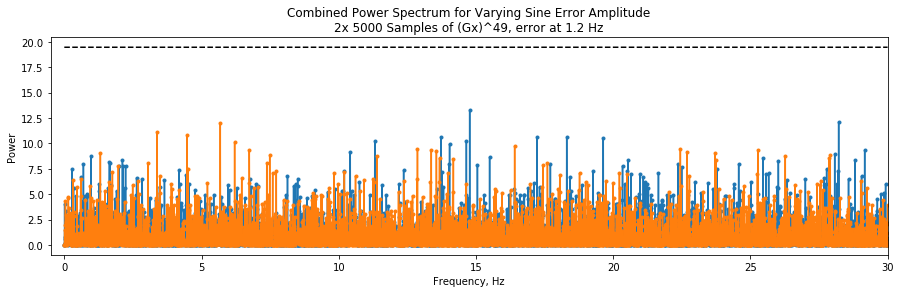

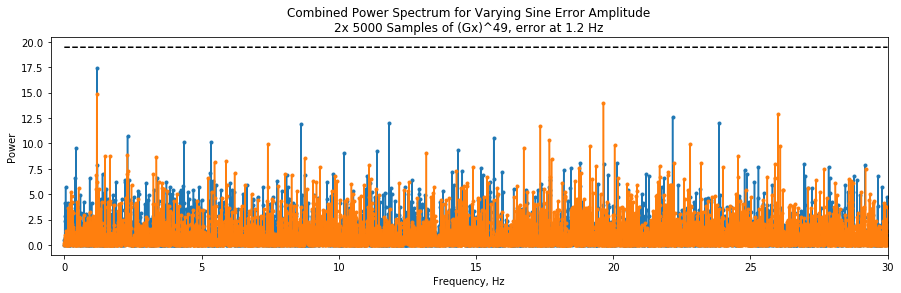

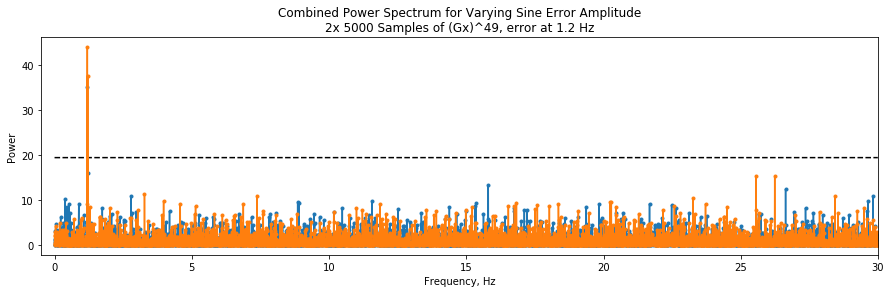

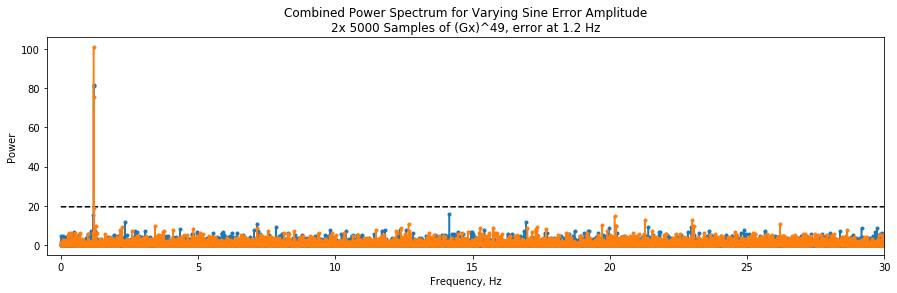

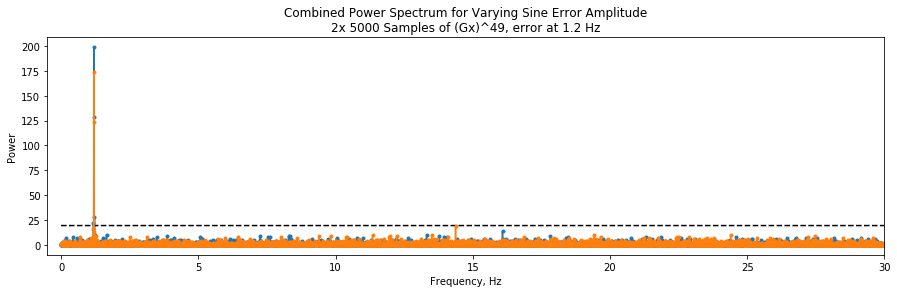

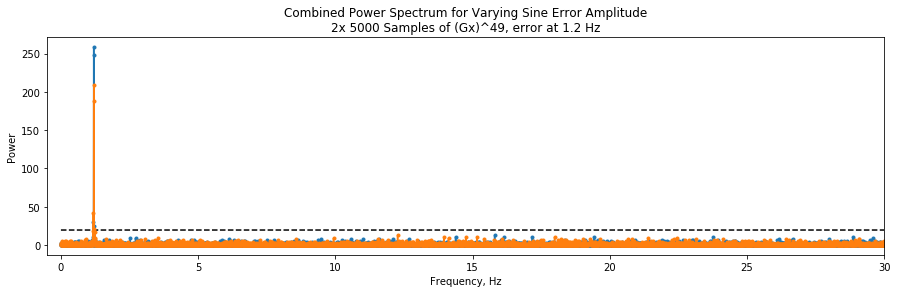

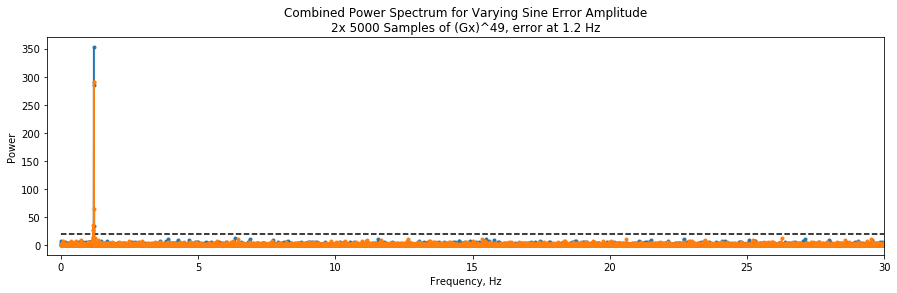

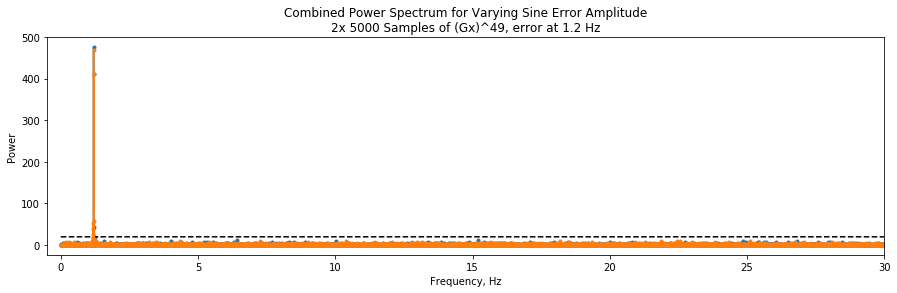

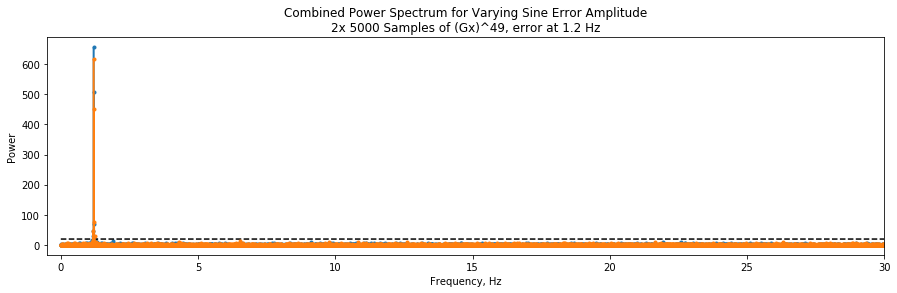

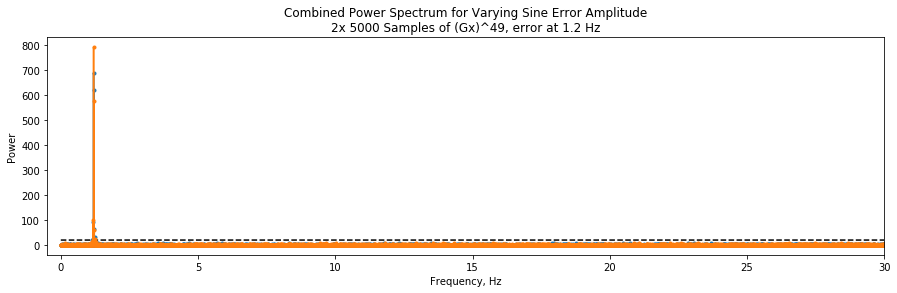

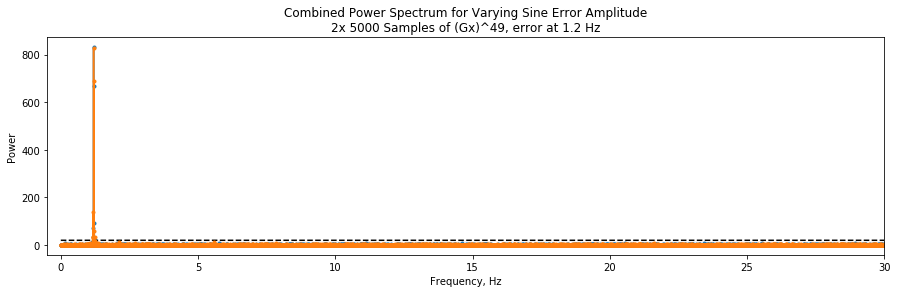

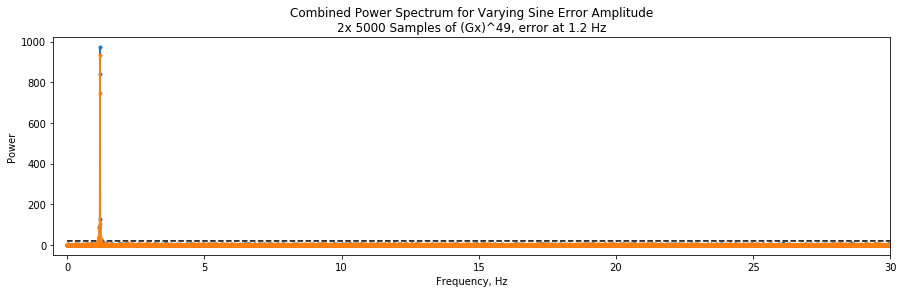

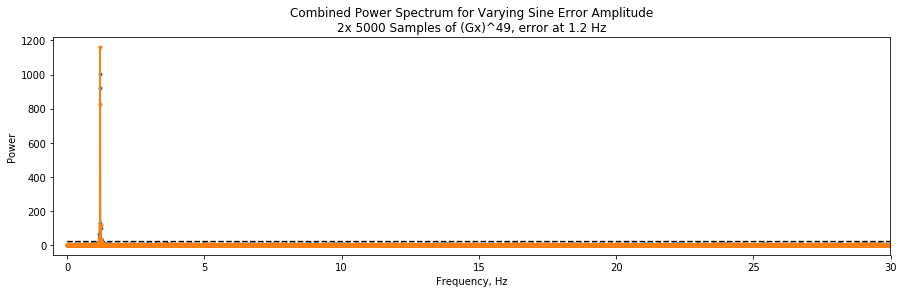

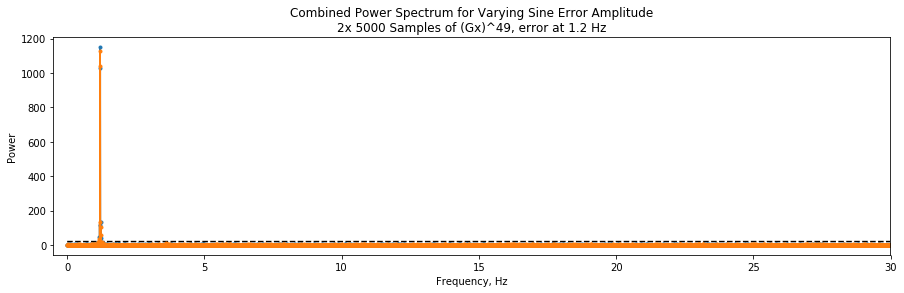

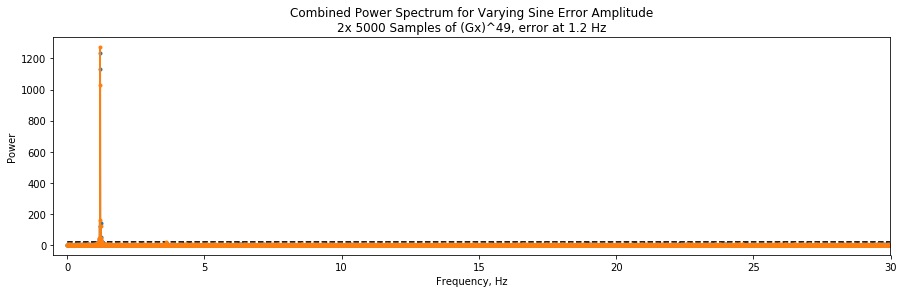

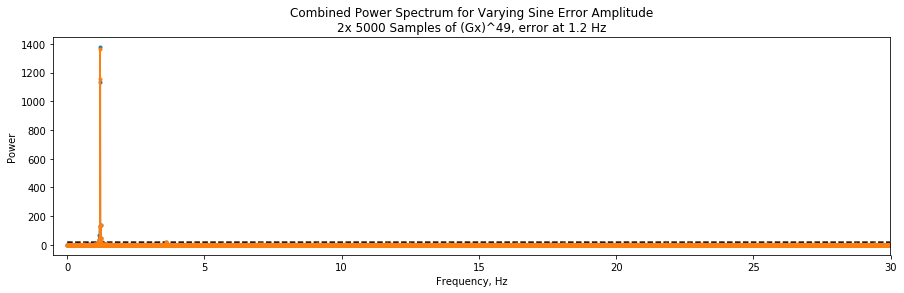

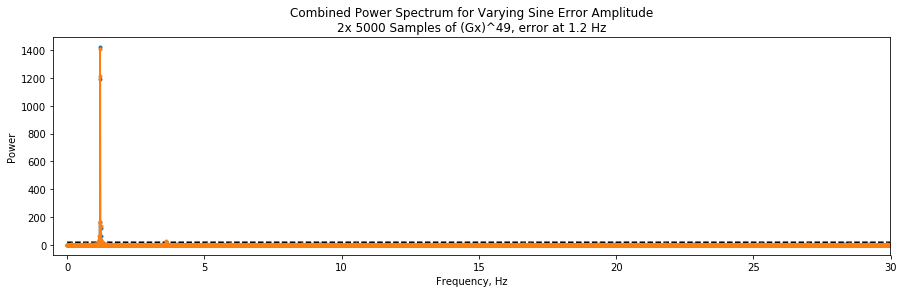

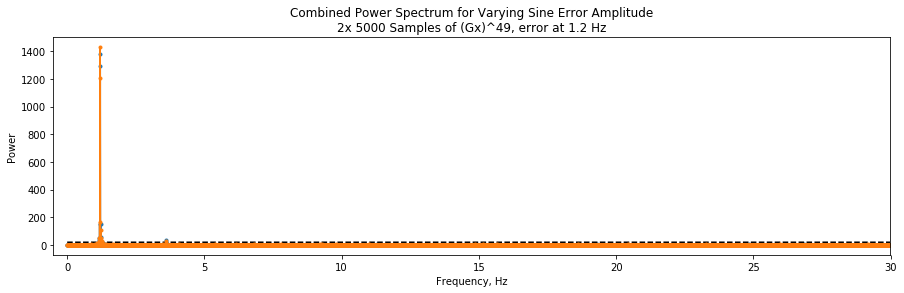

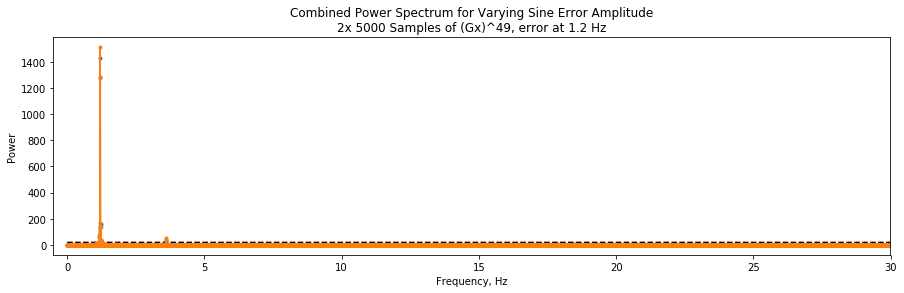

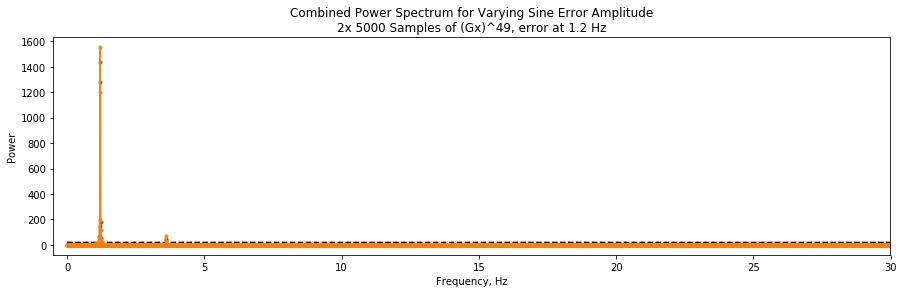

In [79]:
############################ Plot the combined power spectra (plotting together num_experiments for each set of parameters)
for results_list in global_results_list:   
    index = global_results_list.index(results_list) 
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Combined Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"   
        
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Combined Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
        
    
    
    fig = plt.figure(figsize=(15,4))
    confidence_is_plotted = False
    for results in results_list:
        #plot the original power spectrum
        plt.plot(results.frequencies,results.pspepo_power_spectrum[0,0,1,:],ls="solid",marker='.')
        if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
        confidence_is_plotted = True

    
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,results_list[0].frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.show()
    
    #results_list[0].plot_most_drifty_probability(0)


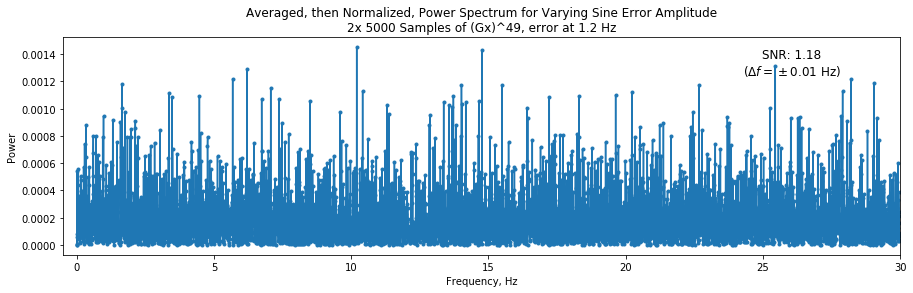

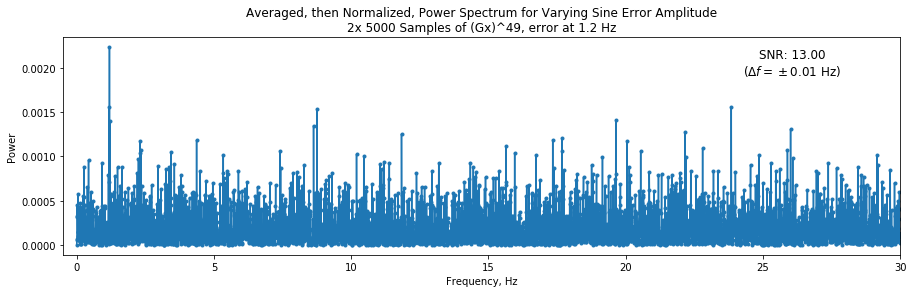

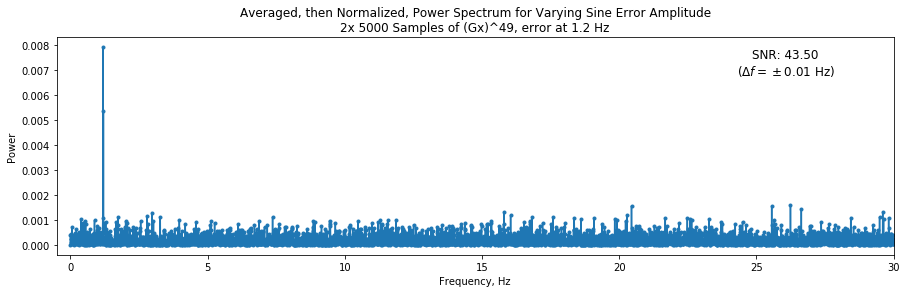

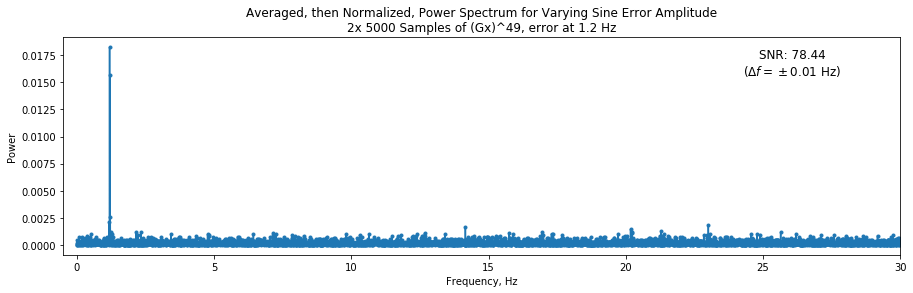

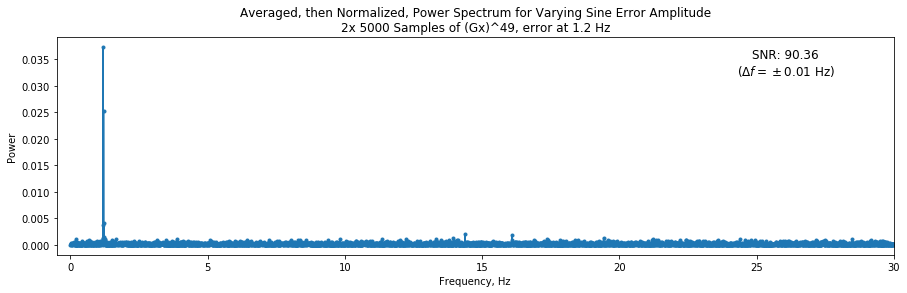

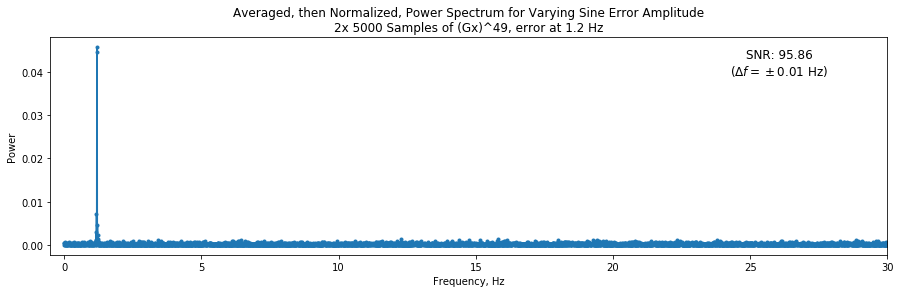

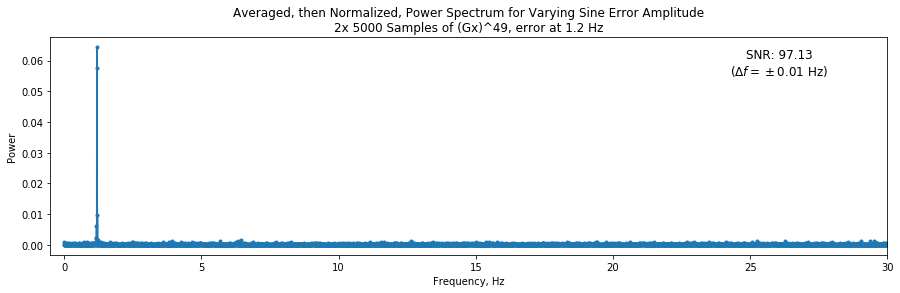

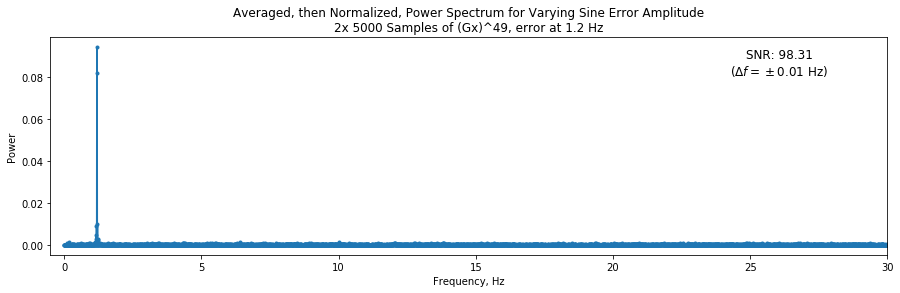

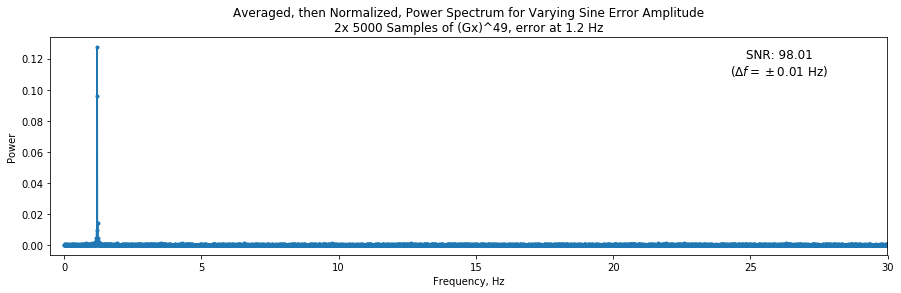

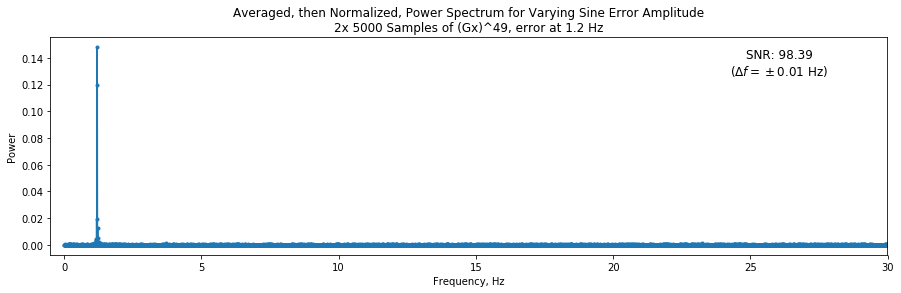

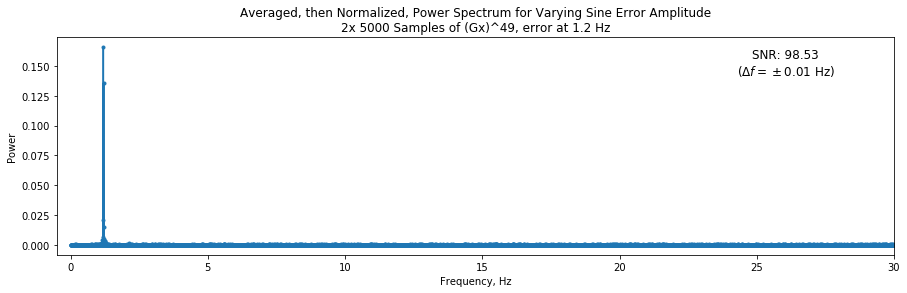

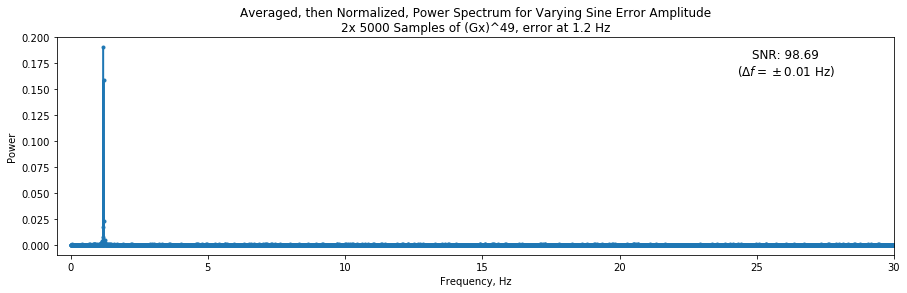

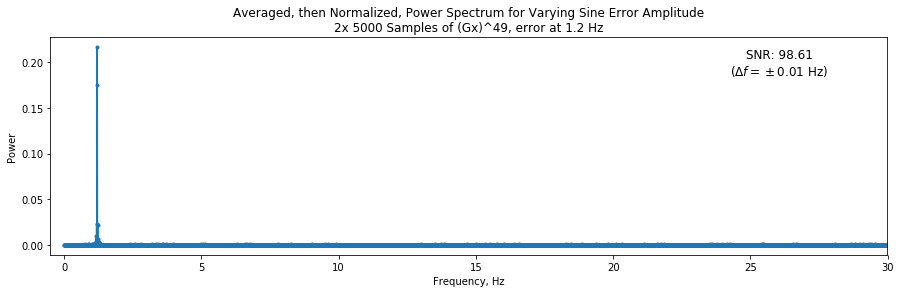

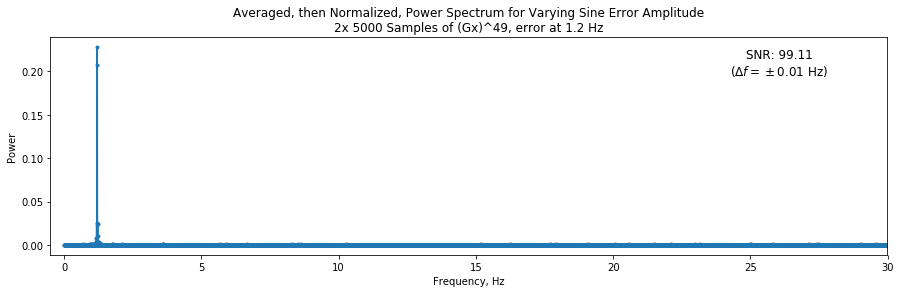

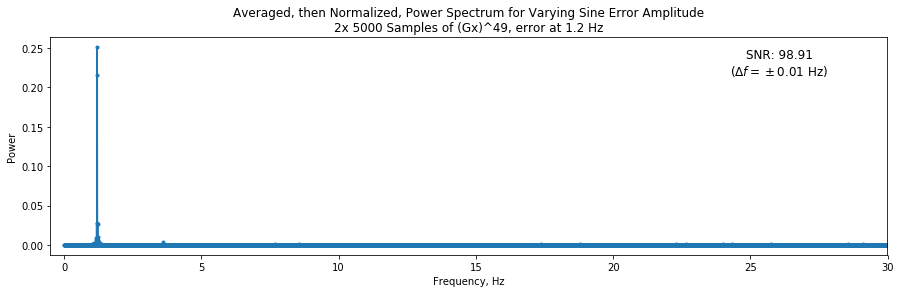

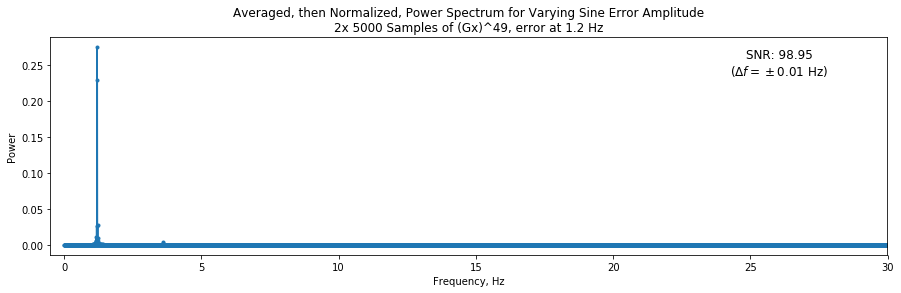

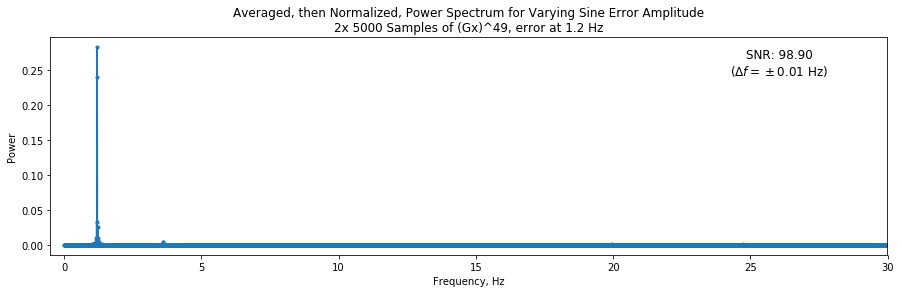

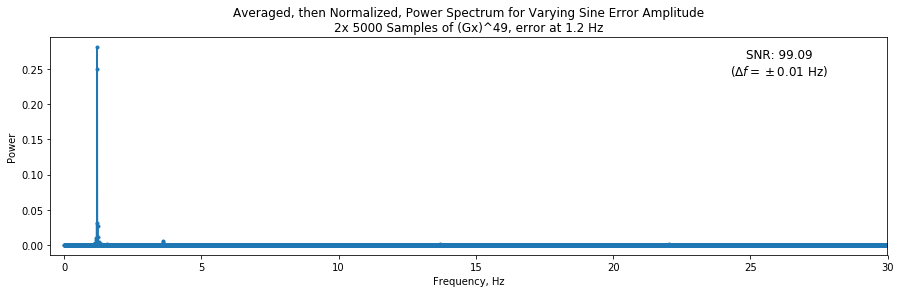

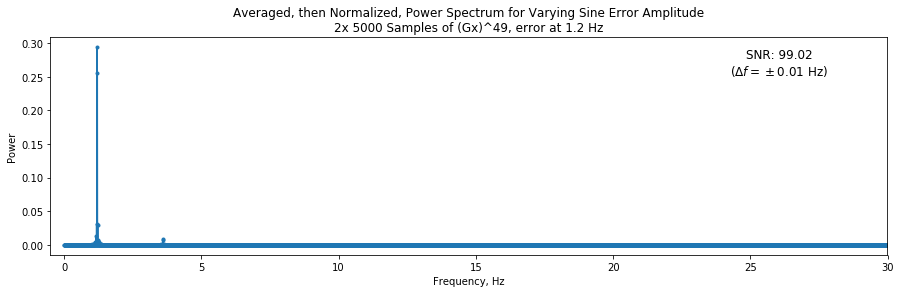

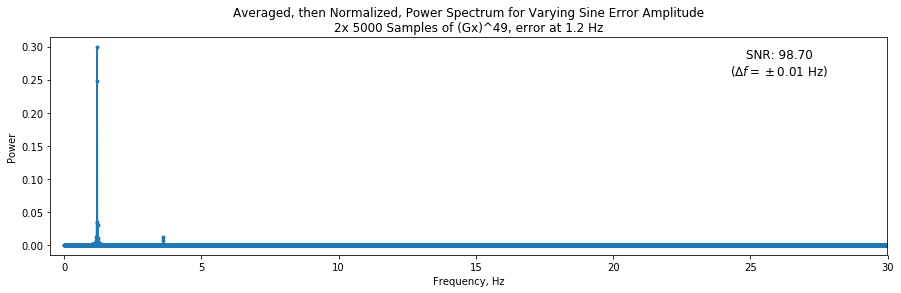

In [80]:
#### Superimpose and average the num_experiments power spectra
#### Normalize the averaged power spectra if necessary
#### also calculate SNR for specified frequency bands

global_snr_list = [0]*num_parameters
for results_list in global_results_list:
    index = global_results_list.index(results_list)
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Superimposed Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"    
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Superimposed Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
        
    superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
    superimposed_frequencies = results_list[0].frequencies
    
    for result in results_list:
        #populate the superimposed power spectrum by adding powers from the num_experiments
        for index2 in range(len(superimposed_power_spectrum)):
            power = result.pspepo_power_spectrum[0,0,1,:][index2]
            superimposed_power_spectrum[index2] += power

    
    averaged = True #here I'm dividing the superimposed power by the number of experiments to get an average
    if averaged:
        superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
        title_string = "Averaged " + title_string[13:]
    global_superimposed_lists[index] = superimposed_power_spectrum
    
    normalized = True #here I'm dividing each averaged and superimposed spectrum by its total number of points
    if normalized:
        if not(averaged) and num_experiments > 1:
            print("Must be averaged before it can be normalized!!!")
        else:
            superimposed_power_spectrum = superimposed_power_spectrum/nSamples
            title_string = "Averaged, then Normalized, " + title_string[9:]
            global_normalized_superimposed_lists[index] = superimposed_power_spectrum

    #calculate SNRs for averaged spectra and add to the global list        
    avg_SNR = SNR(superimposed_frequencies, superimposed_power_spectrum, snr_central_freq, snr_bandwidth)   
    global_snr_list[index] = avg_SNR

    
    fig = plt.figure(figsize=(15,4))
    plt.plot(superimposed_frequencies, superimposed_power_spectrum,ls="solid",marker='.')
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,superimposed_frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.figtext(0.8, 0.75,"SNR: {:.2f}\n$(\Delta f = \pm{}$ Hz)".format(avg_SNR,snr_bandwidth), wrap=True,
            horizontalalignment='center', fontsize=12)
    plt.show()

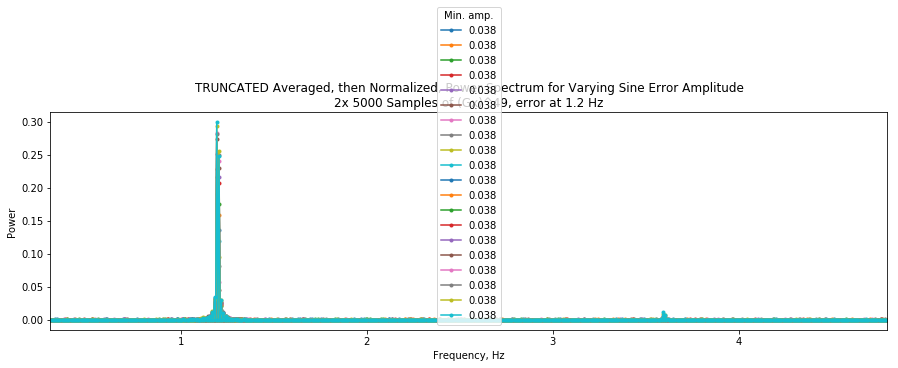

In [81]:
##Plotting the truncated, superimposed power spectrum
plt.figure(figsize=(15,4))
for normalized_power_spectrum in global_normalized_superimposed_lists:
    frequencies = superimposed_frequencies 
    
    mindex = 50
    maxdex = 800
    
    #formatting the legend
    label=variable_params[index]
    legend_string=param_name
    if param_name == "amp":
        label = round(min(variable_params[index]),4)
        legend_string="Min. amp."
    
    plt.plot(frequencies[mindex:maxdex], normalized_power_spectrum[mindex:maxdex],ls="solid",marker='.',
            label=label)

plt.xlabel("Frequency, Hz")
plt.xlim((frequencies[mindex],frequencies[maxdex]))
plt.ylabel("Power")
plt.title("TRUNCATED " + title_string)
plt.legend(title=legend_string)
plt.show()


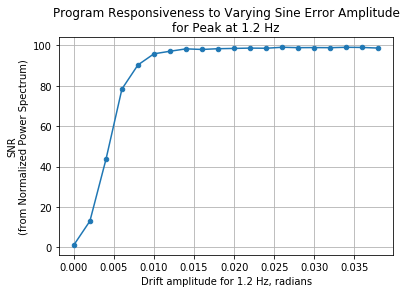

In [82]:
#######here i'll show the results over the varied parameter
index = global_results_list.index(results_list)
x_string = ''
if param_name == "frequency": 
    freq_list = variable_params[index] #not actually a list, this is just the naming convention
    title_string = "Program Responsiveness to Varying Drift Frequencies\nfor Peak at {} Hz".format(freq_of_interest)
    x_string = "Frequency of Drift, Hz"    
elif param_name == "nSamples": 
    nSamples = variable_params[index]
    title_string = "Program Responsiveness to Varying Sample Size\nfor Peak at {} Hz".format(freq_of_interest)
    x_string = "Number of Samples"
elif param_name == "L": 
    gate_string = variable_params[index]
    title_string = "Program Responsiveness to Varying Gate Length\nfor Peak at {} Hz".format(freq_of_interest)
    x_string = "Gate Sequence Length"
elif param_name == "amp": 
    amp_list = variable_params[index] #not actually a list, just convention
    title_string = "Program Responsiveness to Varying Sine Error Amplitude\nfor Peak at {} Hz".format(freq_of_interest)
    x_string = "Drift amplitude for {} Hz, radians".format(freq_of_interest)
    

if param_name != "amp" or special_amp_params == False:
    plt.plot(variable_params,global_snr_list, marker='.',markersize="9")
elif param_name == "amp" and special_amp_params:
    modified_params = [0]*len(variable_params)
    freq_of_interest_index = freq_list.index(freq_of_interest)
    for index4 in range(len(variable_params)):
        modified_params[index4] = variable_params[index4][freq_of_interest_index]
    plt.plot(modified_params,global_snr_list, marker='.',markersize="9")
    x_string = "Drift Amplitude of {} Hz, radians".format(freq_of_interest)
    plt.xticks(rotation=90)
plt.grid()
plt.xlabel(x_string)
plt.title(title_string)
plt.ylabel("SNR\n(from Normalized Power Spectrum)")
plt.show()

In [83]:
#show total rotation angle as a function of time if the varied parameter is L
if param_name == "L":
    lower_i = 0
    upper_i = 1999
    
    plt.figure(figsize=(15,4))
    for list_index in range(0, num_parameters, 5):
        L = variable_params[list_index]
        print("For L value: {}".format(L))
        angle_list = global_angle_list[list_index]
        print(angle_list)
        ideal_angle_list = global_angle_list[list_index]
        times = global_timestamps_list[list_index]
        #plt.plot(times, ideal_angle_list, ls='dashed', label="Ideal")
        plt.plot(times, angle_list, marker='.', label=L)
    plt.title("Time-Dependent Rotation from L-gates")
    plt.plot(times, [np.pi/2]*len(times), ls="dashed", label="Ideal Pi/2")
    plt.xlabel("Time, seconds")
    plt.yticks(np.linspace(0, np.pi, 5), ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    plt.xlim(times[lower_i], times[upper_i])
    plt.ylabel("Angle, radians\n(Displayed between 0 and $\pi$)")
    plt.legend(loc="lower right",title="L")
    plt.show()

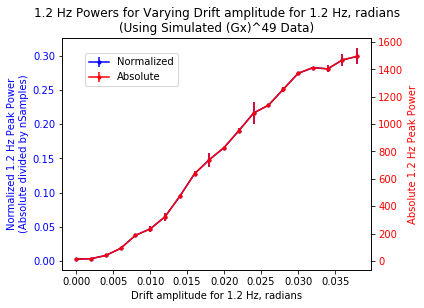

In [84]:
###Show how peak power changes as you vary the specified parameter.
### If it's sample size, list some statistics listing the mean normalized
### power across sample sizes. Ideally, this should be a constant value 
### as long as all other parameters are the same.

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel(x_string)
ax1.set_ylabel('Normalized {} Hz Peak Power\n(Absolute divided by nSamples)'.format(freq_of_interest), color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

#if you're applying multiple frequencies per experiment, you only want to see the amplitude of the freq_of_interest
if param_name=='amp' and len(amp_list) > 1:
    x_values = modified_params
else:
    x_values = variable_params
    
ax1.errorbar(x_values, global_avg_normalized_peak_power_list, yerr=global_std_dev_normalized_peak_power_list,\
             marker='.',label="Normalized".format(freq_of_interest), color='blue', fmt='-o')
ax2.set_ylabel('Absolute {} Hz Peak Power'.format(freq_of_interest), color="red")
ax2.errorbar(x_values, global_avg_peak_power_list, yerr=global_std_dev_peak_power_list,\
             marker='.', label="Absolute", color="red", fmt='-o')
ax2.tick_params(axis='y', labelcolor='red')
fig.tight_layout()
fig.legend(loc=(0.2, 0.72))
plt.title("{} Hz Powers for Varying {}\n(Using Simulated {} Data)".format(freq_of_interest, x_string, gate_string))
plt.show()

if param_name=='nSamples':
    print("Distribution of Normalized Powers for {} Hz:".format(freq_of_interest))
    print("Mean: {:.4f}".format(np.mean(global_avg_normalized_peak_power_list))) #takes the mean of the mean power per parameter set
    print("Std. Dev: {:.4f}".format(np.std(global_avg_normalized_peak_power_list))) #takes the std dev of the mean powers
    print("\n**Uses {} powers to determine this, where each power is\nobtained by normalizing the power spectra of {} identical \nexperiments with the same sample size, finding the peak of those normalized spectra,\n and then averaging those {} powers.".format(num_parameters, num_experiments, num_experiments))
    print("The standard deviation is the standard deviation\n of these {} peak powers.".format(num_parameters))

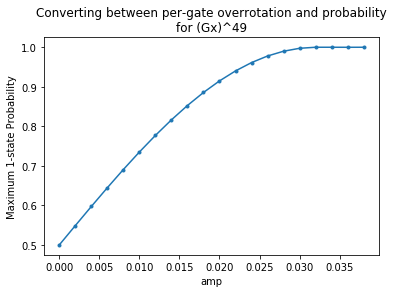

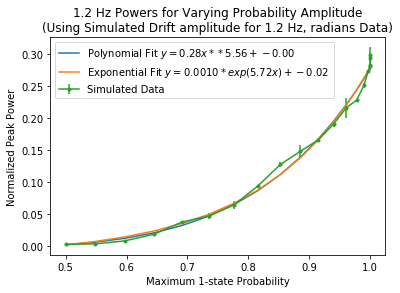

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in log



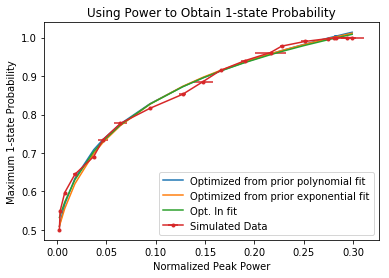

In [85]:
###If amplitude the varied parameter, show how the peak power changes
###  with amplitude variation, and relate amplitude variation to 1-state probability.
if param_name == 'amp' and len(variable_params[0]) == 1: 
    global_max_probs_list = np.asarray(global_max_probs_list)
    global_avg_normalized_peak_power_list = np.asarray(global_avg_normalized_peak_power_list)
    
    plt.plot(variable_params, global_max_probs_list, marker='.')
    plt.title("Converting between per-gate overrotation and probability\nfor {}".format(gate_string))
    plt.xlabel(param_name)
    plt.ylabel("Maximum 1-state Probability")
    plt.show()
    
    ##### Define various fits and then find best fit
    def polynomial(x, a, b, c):
        return a*x**b + c
    def exp(x, a, b, c):
        return a*np.exp(b*x) + c
    def ln(x, a, b, c, d):
        return a*np.log(b*x + c) + d
    
    popt, pcov = curve_fit(polynomial, global_max_probs_list, global_avg_normalized_peak_power_list,sigma=global_std_dev_normalized_peak_power_list, absolute_sigma=True)
    def opt_poly_prob_to_power(x):
        return popt[0]*x**popt[1] + popt[2]
    
    e_popt, e_pcov = curve_fit(exp, global_max_probs_list, global_avg_normalized_peak_power_list,sigma=global_std_dev_normalized_peak_power_list, absolute_sigma=True)
    def opt_exp_prob_to_power(x):
        return e_popt[0]*np.exp(e_popt[1]*x) + e_popt[2]
    
    plt.plot(global_max_probs_list, opt_poly_prob_to_power(global_max_probs_list), label="Polynomial Fit $y={:.2f}x**{:.2f} + {:.2f}$".format(popt[0], popt[1], popt[2]))
    plt.plot(global_max_probs_list, opt_exp_prob_to_power(global_max_probs_list), label="Exponential Fit $y={:.4f}*exp({:.2f}x) + {:.2f}$".format(e_popt[0], e_popt[1], e_popt[2]))
    plt.errorbar(global_max_probs_list, global_avg_normalized_peak_power_list, yerr=global_std_dev_normalized_peak_power_list,\
             marker='.',label="Simulated Data".format(freq_of_interest), fmt='-o')
    plt.xlabel("Maximum 1-state Probability")
    plt.legend(loc="upper left")
    plt.ylabel("Normalized Peak Power")
    plt.title("{} Hz Powers for Varying Probability Amplitude\n(Using Simulated {} Data)".format(freq_of_interest, x_string, gate_string))
    plt.show()
    
    #different fit options for going from power to prob
    def opt_poly_power_to_prob(x):
        return ((x - popt[2])/popt[0])**(1/popt[1])
    
    def opt_exp_power_to_prob(x):
        return (1/e_popt[1])*np.log((x - e_popt[2])/e_popt[0])
    
    #this just does a raw ln fit to the reverse data; it doesn't use the prior optimized values
    ln_popt, ln_pcov = curve_fit(ln, global_avg_normalized_peak_power_list, global_max_probs_list)
    def optimized_ln_power_to_prob(x):
        return ln_popt[0]*np.log(ln_popt[1]*x + ln_popt[2]) + ln_popt[3]

     
    plt.plot(global_avg_normalized_peak_power_list, opt_poly_power_to_prob(global_avg_normalized_peak_power_list), label="Optimized from prior polynomial fit")
    plt.plot(global_avg_normalized_peak_power_list, opt_exp_power_to_prob(global_avg_normalized_peak_power_list), label="Optimized from prior exponential fit")
    plt.plot(global_avg_normalized_peak_power_list, optimized_ln_power_to_prob(global_avg_normalized_peak_power_list), label="Opt. ln fit")
    plt.errorbar(global_avg_normalized_peak_power_list, global_max_probs_list, xerr=global_std_dev_normalized_peak_power_list, marker='.', label="Simulated Data")
    plt.title("Using Power to Obtain 1-state Probability")
    plt.xlabel("Normalized Peak Power")
    plt.ylabel("Maximum 1-state Probability")
    plt.legend()
    plt.show()

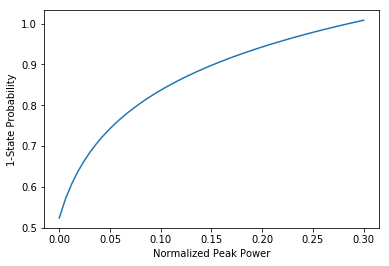

1-prob due to power of 0.15 is: 0.898


In [98]:
def manual_exp_power_to_prob(x, a, b, c):
        return (1/b)*np.log((x - c)/a)
    
a = 0.0010
b=5.72
c=-0.02

fake_powers = np.linspace(0.0, 0.3)
plt.plot(fake_powers, manual_exp_power_to_prob(fake_powers, a, b, c))
plt.xlabel("Normalized Peak Power")
plt.ylabel("1-State Probability")
plt.show()

## >>> If you want to calculate a prob based on a power, do it below.
power_val = 0.15
print("1-prob due to power of {} is: {:.3f}".format(power_val, manual_exp_power_to_prob(power_val, a,b,c)))